In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim

# 数据集信息

In [2]:
print('训练集')
train_df = pd.read_csv('../input/digit-recognizer/train.csv')
n_train = len(train_df)
n_pixels = len(train_df.columns) - 1
n_class = len(set(train_df['label']))
print(f'样本数量：{n_train}')
print(f'图片大小：{n_pixels}')
print(f'类数量：{n_class}')

训练集
样本数量：42000
图片大小：784
类数量：10


In [3]:
print('测试集')
test_df = pd.read_csv('../input/digit-recognizer/test.csv')
n_test = len(test_df)
n_pixels = len(test_df.columns)
print(f'样本数量：{n_test}')
print(f'图片大小：{n_pixels}')

测试集
样本数量：28000
图片大小：784


# 数据集可视化

In [4]:
random_sel = np.random.randint(len(train_df), size=8)
data = (train_df.iloc[random_sel, 1:].values.reshape(-1,1,28,28)/255.)

6, 5, 1, 1, 0, 2, 7, 1


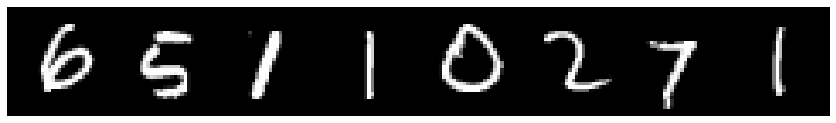

In [5]:
grid = make_grid(torch.Tensor(data), nrow=8)
plt.rcParams['figure.figsize'] = (16, 2)
plt.imshow(grid.numpy().transpose((1,2,0)))
plt.axis('off')
plt.show
print(*list(train_df.iloc[random_sel, 0].values), sep = ', ')

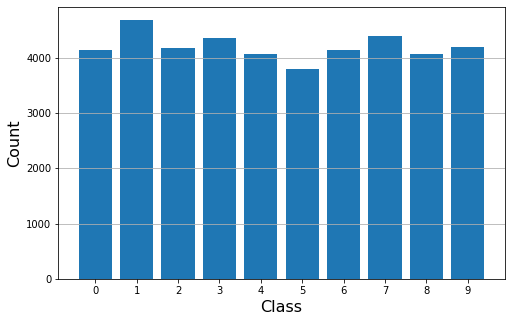

In [6]:
plt.figure(figsize=(8,5))
plt.bar(train_df['label'].value_counts().index, train_df['label'].value_counts())
plt.xticks(np.arange(n_class))
plt.xlabel('Class', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.grid('on', axis='y')
plt.show()

# 构建dataset

In [7]:
class MNIST_data(Dataset):
    def __init__(self, csv_file, dataset_type, transform=transforms.Compose([transforms.ToPILImage(),
                                                                transforms.ToTensor(),
                                                                transforms.Normalize(mean=(0.5,), std=(0.5,))])):
        df = csv_file
        if dataset_type == 'test':
            self.X = df.values.reshape((-1, 28, 28)).astype(np.uint8)[:, :, :, None]
            self.y = None
        else:
            self.X = df.iloc[:, 1:].values.reshape((-1, 28, 28)).astype(np.uint8)[:, :, :, None]
            self.y = torch.from_numpy(df.iloc[:, 0].values)
        self.transform = transform
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        if self.y is not None:
            return self.transform(self.X[idx]), self.y[idx]
        else:
            return self.transform(self.X[idx])

In [8]:
batch_size = 64

train_dataset = MNIST_data(train_df,
                           dataset_type='train',
                           transform=transforms.Compose([
                            transforms.ToPILImage(),
                            transforms.RandomRotation(degrees=20),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=(0.5,), std=(0.5,))]))
test_dataset = MNIST_data(test_df,
                          dataset_type='test')

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

# 构建模型

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        hidden_size = 500
        self.features3 = nn.Sequential(
            nn.Linear(28 * 28, hidden_size),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(hidden_size, 10)
        )
        self.features3_1 = nn.Sequential(
            nn.Linear(28 * 28, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 10)
        )
        self.features4 = nn.Sequential(
            nn.Linear(28 * 28, hidden_size),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(hidden_size, 100),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(100, 10),
        )
        self.features5 = nn.Sequential(
            nn.Linear(28 * 28, hidden_size),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(hidden_size, 200),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(100, 10),
        )
    
    def forward(self, x):
        # x = nn.Flatten(x)
        x = self.features3_1(x)
        return x
    

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss().to(device)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
print(model)

Net(
  (features3): Sequential(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=500, out_features=10, bias=True)
  )
  (features3_1): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
  )
  (features4): Sequential(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=500, out_features=100, bias=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=10, bias=True)
  )
  (features5): Sequential(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=500, out_features=200, bias=True)
    

# 训练模型

In [11]:
def train(epoch):
    loss_list = []
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.reshape(-1, 28 * 28).to(device)
        target = target.to(device)
        #print(data[1])
        output = model(data)
        loss = criterion(output, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (batch_idx + 1) % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                       100. * (batch_idx + 1) / len(train_loader), loss.item()))
            loss_list.append(loss.item())
    
    exp_lr_scheduler.step()
    return loss_list

Train Epoch: 0 [3200/42000 (8%)]	Loss: 0.907041
Train Epoch: 0 [6400/42000 (15%)]	Loss: 0.576105
Train Epoch: 0 [9600/42000 (23%)]	Loss: 0.590087
Train Epoch: 0 [12800/42000 (30%)]	Loss: 0.389857
Train Epoch: 0 [16000/42000 (38%)]	Loss: 0.335493
Train Epoch: 0 [19200/42000 (46%)]	Loss: 0.292748
Train Epoch: 0 [22400/42000 (53%)]	Loss: 0.465173
Train Epoch: 0 [25600/42000 (61%)]	Loss: 0.432185
Train Epoch: 0 [28800/42000 (68%)]	Loss: 0.341711
Train Epoch: 0 [32000/42000 (76%)]	Loss: 0.391231
Train Epoch: 0 [35200/42000 (84%)]	Loss: 0.343521
Train Epoch: 0 [38400/42000 (91%)]	Loss: 0.361000
Train Epoch: 0 [41600/42000 (99%)]	Loss: 0.400883
Train Epoch: 1 [3200/42000 (8%)]	Loss: 0.315943
Train Epoch: 1 [6400/42000 (15%)]	Loss: 0.496202
Train Epoch: 1 [9600/42000 (23%)]	Loss: 0.311237
Train Epoch: 1 [12800/42000 (30%)]	Loss: 0.180729
Train Epoch: 1 [16000/42000 (38%)]	Loss: 0.271052
Train Epoch: 1 [19200/42000 (46%)]	Loss: 0.222512
Train Epoch: 1 [22400/42000 (53%)]	Loss: 0.321523
Train Ep

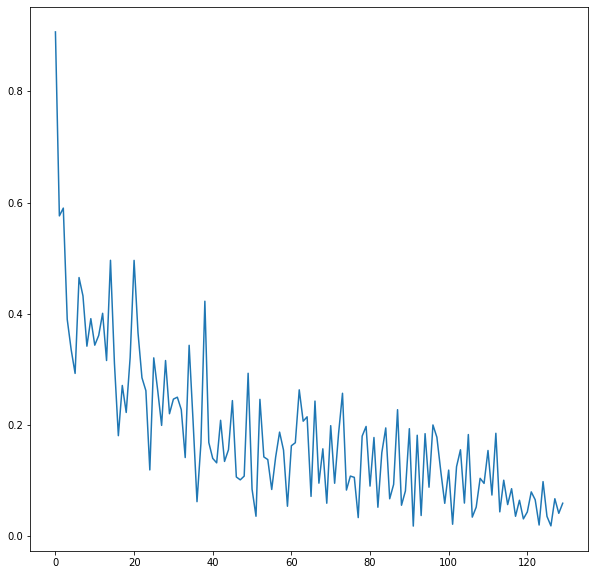

In [12]:
log = []
n_epochs = 10
for epoch in range(n_epochs):
    loss = train(epoch)
    log += loss
   
plt.figure(figsize=(10, 10))
plt.plot(log)
plt.show()

In [13]:
!nvidia-smi

Mon Mar 14 12:06:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    32W / 250W |    829MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [14]:
x=[1,2]
x+=[1,2]
x

[1, 2, 1, 2]